In [51]:
import tensorflow as tf
import numpy as np
#from utils import build_model
import pandas as pd
from tqdm import tqdm
import imageio
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D, Dropout, Flatten, Dense
from keras.regularizers import l2
import statsmodels.api as sm
from utils import build_model, find_closest_element, Fy
from scipy.stats import norm

In [7]:
checkpoint_path = '../../../../data/models/mc_dropout_cil/export/'

In [8]:
model = build_model()
model.load_weights(tf.train.latest_checkpoint(checkpoint_path))

In [9]:
# all training images and paths
path_all_imgs = '../../../../commaai_code/02_write_shards_optional/cil_shards/df_paths.csv'
all_img_df = pd.read_csv(path_all_imgs)
img_path_base = '../../../../data/commaai/test_files/val_files_unfiltered/'
density_path= '../../../../data/commaai/density/gaussian_density.csv'
density = pd.read_csv(density_path)
all_img_df = all_img_df[np.abs(all_img_df['true_y']) < 40].reset_index()

In [ ]:
# extract Bzetas by reading in images and predicting
labels = []
preds = []
for i in tqdm(range(0,all_img_df.shape[0])): 
    img = imageio.imread(str(img_path_base + all_img_df.loc[i,'path']))[:,:,0:3]/255
    pred = model.predict(img.reshape(1,66,200,3))
    label = all_img_df.loc[i,'true_y']
    labels.append(label)       
    preds.append(pred)

# rearrange to arrays
labels = np.array(labels)
preds = np.array(preds)

 85%|████████▍ | 80231/94570 [6:44:10<1:11:20,  3.35it/s] 

In [ ]:
np.save('preds_cil.npy', preds)
np.save('labels_cil.npy', labels)

In [ ]:
np.mean((labels - preds.reshape(10472,))**2)

In [ ]:
np.mean(np.abs((labels - preds.reshape(10472,))))

In [ ]:
np.mean([(labels - preds.reshape(10472,)) <= 6])

In [ ]:
np.mean([(labels - preds.reshape(10472,)) <= 2])

In [ ]:
plt.scatter(labels, preds.reshape(10472,), alpha = 0.1)
plt.plot([-40,40], [-40,40], color = 'red', alpha = 0.2)

## MC-Dropout

In [52]:
#preds_samp = np.load('mc_preds.npy')
preds = np.load('preds_cil.npy')
labels = np.load('labels_cil.npy')
density_path= '../../../../data/commaai/density/gaussian_density.csv'
density = pd.read_csv(density_path)

In [53]:
preds_z = np.append(np.load('../../../../data/commaai/predictions/mc_dropout/cil_tr_labels_1.npy'), 
                  np.load('../../../../data/commaai/predictions/mc_dropout/cil_tr_labels_2.npy'), axis = 0)

In [54]:
preds_l = np.append(np.load('../../../../data/commaai/predictions/mc_dropout/cil_labels_1.npy'), 
                  np.load('../../../../data/commaai/predictions/mc_dropout/cil_labels_2.npy'), axis = 0)

In [55]:
preds_1 = np.append(np.load('../../../../data/commaai/predictions/mc_dropout/mc_preds_cil_1.npy'), 
                  np.load('../../../../data/commaai/predictions/mc_dropout/mc_preds_cil_2.npy'), axis = 0)
preds_mc_z = np.mean(preds_1, axis = 1)

In [56]:
preds_mc_y = np.array([density.loc[find_closest_element(norm.cdf(float(x)), density['cdf']),'axes'] for x in preds_mc_z])

In [58]:
print("Performance of models without and with uncertainty" +
     "\nMSE:" +
      "\nwithout uncertainty: " + str(np.mean((labels - preds.reshape(94570,))**2)) +
      "\nwith uncertainty: " + str(np.mean((labels - preds_mc_y.reshape(94570,))**2)) +
      "\nMAE:" +
      "\nwithout uncertainty: " + str(np.mean(np.abs(labels - preds.reshape(94570,)))) +
      "\nwith uncertainty: " + str(np.mean(np.abs(labels - preds_mc_y.reshape(94570,)))) +
      "\nAccuracy :" +
      "\nwithout uncertainty: " + str(np.mean([np.abs((labels - preds.reshape(94570,))) <= 6])) +
      "\nwith uncertainty: " + str(np.mean([np.abs((labels - preds_mc_y.reshape(94570,))) <= 6])) +
      "\nAccuracy II:" +
      "\nwithout uncertainty: " + str(np.mean([np.abs((labels - preds.reshape(94570,))) <= 2])) +
      "\nwith uncertainty: " + str(np.mean([(labels - preds_mc_y.reshape(94570,)) <= 2])) 
     )

Performance of models without and with uncertainty
MSE:
without uncertainty: 11.460971872097149
with uncertainty: 368.69645702237983
MAE:
without uncertainty: 2.000447588015797
with uncertainty: 9.943009606874142
Accuracy :
without uncertainty: 0.9580310880829016
with uncertainty: 0.7134397800571005
Accuracy II:
without uncertainty: 0.6564343872263931
with uncertainty: 0.7381410595326213


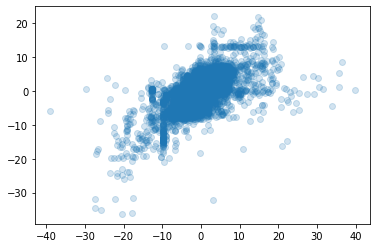

In [59]:
plt.scatter(preds_l[0:40000], preds_mc_y[0:40000] , alpha = 0.2)

In [41]:
np.mean((preds_l.reshape(94570,) - preds_mc_z.reshape(94570,))**2)

8.156085649190267

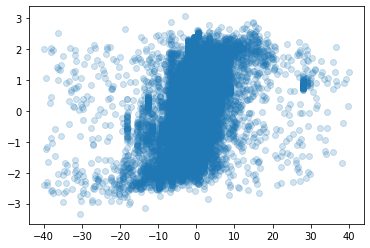

In [19]:
plt.scatter(labels, preds, alpha = 0.2)